# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
%qtconsole

In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.342041
sanity check: 2.302585


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.202928 analytic: 0.202928, relative error: 3.076489e-07
numerical: -0.605186 analytic: -0.605187, relative error: 2.534313e-08
numerical: 1.141405 analytic: 1.141405, relative error: 1.089222e-08
numerical: 0.666348 analytic: 0.666347, relative error: 4.503819e-08
numerical: -0.285008 analytic: -0.285008, relative error: 3.920443e-08
numerical: -0.687791 analytic: -0.687791, relative error: 1.662353e-08
numerical: 1.177700 analytic: 1.177700, relative error: 1.284297e-08
numerical: -0.796385 analytic: -0.796385, relative error: 6.790314e-08
numerical: -4.449977 analytic: -4.449977, relative error: 1.411990e-08
numerical: -1.322764 analytic: -1.322764, relative error: 4.024968e-08
numerical: 4.336077 analytic: 4.336077, relative error: 2.639210e-09
numerical: -6.254694 analytic: -6.254694, relative error: 1.179826e-10
numerical: 1.626069 analytic: 1.626069, relative error: 3.967857e-08
numerical: -3.143679 analytic: -3.143679, relative error: 2.347331e-08
numerical: 1.53698

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.342041e+00 computed in 0.059948s
vectorized loss: 2.342041e+00 computed in 0.013995s
Loss difference: 0.000000
Gradient difference: 0.000000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = list(np.arange(1e-7,1e-5,5e-7))
regularization_strengths = list(np.arange(1e1, 1e4,1e2))
#import pdb; pdb.set_trace()
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax  = Softmax()
        loss_hist = softmax.train(X_train, y_train, lr, rs, num_iters=1000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr,rs)] = [acc_train, acc_val]
        if acc_val> best_val:
            best_val = acc_val
            best_svm = softmax   #committed an error of writing best_softmax as best_svm
        print(lr,rs, results[(lr,rs)])       
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-07 10.0 [0.2335918367346939, 0.231]
1e-07 110.0 [0.2294081632653061, 0.242]
1e-07 210.0 [0.2370612244897959, 0.233]
1e-07 310.0 [0.2297142857142857, 0.237]
1e-07 410.0 [0.22957142857142857, 0.225]
1e-07 510.0 [0.23679591836734695, 0.244]
1e-07 610.0 [0.2383265306122449, 0.253]
1e-07 710.0 [0.22920408163265307, 0.233]
1e-07 810.0 [0.2399387755102041, 0.239]
1e-07 910.0 [0.24020408163265305, 0.259]
1e-07 1010.0 [0.21914285714285714, 0.214]
1e-07 1110.0 [0.23551020408163265, 0.227]
1e-07 1210.0 [0.2267142857142857, 0.225]
1e-07 1310.0 [0.2426734693877551, 0.234]
1e-07 1410.0 [0.23948979591836736, 0.255]
1e-07 1510.0 [0.22995918367346938, 0.239]
1e-07 1610.0 [0.2317551020408163, 0.24]
1e-07 1710.0 [0.24385714285714286, 0.249]
1e-07 1810.0 [0.23485714285714285, 0.206]
1e-07 1910.0 [0.23604081632653062, 0.272]
1e-07 2010.0 [0.23281632653061224, 0.24]
1e-07 2110.0 [0.24728571428571428, 0.255]
1e-07 2210.0 [0.24287755102040817, 0.245]
1e-07 2310.0 [0.24314285714285713, 0.247]
1e-07 2410.0 [

1.1e-06 110.0 [0.3403265306122449, 0.355]
1.1e-06 210.0 [0.3475714285714286, 0.343]
1.1e-06 310.0 [0.35914285714285715, 0.343]
1.1e-06 410.0 [0.3610408163265306, 0.366]
1.1e-06 510.0 [0.3686734693877551, 0.367]
1.1e-06 610.0 [0.37151020408163266, 0.362]
1.1e-06 710.0 [0.3816734693877551, 0.373]
1.1e-06 810.0 [0.3813877551020408, 0.383]
1.1e-06 910.0 [0.3825918367346939, 0.386]
1.1e-06 1010.0 [0.3882244897959184, 0.401]
1.1e-06 1110.0 [0.3912040816326531, 0.387]
1.1e-06 1210.0 [0.3894285714285714, 0.382]
1.1e-06 1310.0 [0.3930612244897959, 0.393]
1.1e-06 1410.0 [0.3922857142857143, 0.397]
1.1e-06 1510.0 [0.3923673469387755, 0.388]
1.1e-06 1610.0 [0.39514285714285713, 0.396]
1.1e-06 1710.0 [0.39485714285714285, 0.385]
1.1e-06 1810.0 [0.39577551020408164, 0.385]
1.1e-06 1910.0 [0.398734693877551, 0.4]
1.1e-06 2010.0 [0.39548979591836736, 0.395]
1.1e-06 2110.0 [0.3969591836734694, 0.398]
1.1e-06 2210.0 [0.3970204081632653, 0.398]
1.1e-06 2310.0 [0.39687755102040817, 0.391]
1.1e-06 2410.0 [

1.6e-06 9210.0 [0.3633877551020408, 0.368]
1.6e-06 9310.0 [0.3576734693877551, 0.374]
1.6e-06 9410.0 [0.3656530612244898, 0.375]
1.6e-06 9510.0 [0.3557142857142857, 0.371]
1.6e-06 9610.0 [0.3643265306122449, 0.379]
1.6e-06 9710.0 [0.35722448979591837, 0.361]
1.6e-06 9810.0 [0.3686122448979592, 0.371]
1.6e-06 9910.0 [0.3419591836734694, 0.336]
2.1e-06 10.0 [0.357, 0.334]
2.1e-06 110.0 [0.37544897959183676, 0.367]
2.1e-06 210.0 [0.3808979591836735, 0.383]
2.1e-06 310.0 [0.38693877551020406, 0.384]
2.1e-06 410.0 [0.3978979591836735, 0.394]
2.1e-06 510.0 [0.39210204081632655, 0.386]
2.1e-06 610.0 [0.40122448979591835, 0.395]
2.1e-06 710.0 [0.40561224489795916, 0.393]
2.1e-06 810.0 [0.38687755102040816, 0.372]
2.1e-06 910.0 [0.4021224489795918, 0.393]
2.1e-06 1010.0 [0.3782857142857143, 0.37]
2.1e-06 1110.0 [0.39755102040816326, 0.4]
2.1e-06 1210.0 [0.39155102040816325, 0.405]
2.1e-06 1310.0 [0.3919183673469388, 0.393]
2.1e-06 1410.0 [0.40261224489795916, 0.399]
2.1e-06 1510.0 [0.3965918367

2.5999999999999997e-06 6310.0 [0.36828571428571427, 0.373]
2.5999999999999997e-06 6410.0 [0.3584081632653061, 0.367]
2.5999999999999997e-06 6510.0 [0.3601020408163265, 0.375]
2.5999999999999997e-06 6610.0 [0.3686530612244898, 0.376]
2.5999999999999997e-06 6710.0 [0.3629387755102041, 0.366]
2.5999999999999997e-06 6810.0 [0.356, 0.362]
2.5999999999999997e-06 6910.0 [0.35946938775510207, 0.367]
2.5999999999999997e-06 7010.0 [0.3543877551020408, 0.362]
2.5999999999999997e-06 7110.0 [0.3484285714285714, 0.363]
2.5999999999999997e-06 7210.0 [0.3579387755102041, 0.363]
2.5999999999999997e-06 7310.0 [0.3529387755102041, 0.353]
2.5999999999999997e-06 7410.0 [0.35606122448979594, 0.366]
2.5999999999999997e-06 7510.0 [0.3344489795918367, 0.332]
2.5999999999999997e-06 7610.0 [0.34191836734693876, 0.343]
2.5999999999999997e-06 7710.0 [0.357734693877551, 0.375]
2.5999999999999997e-06 7810.0 [0.3424081632653061, 0.363]
2.5999999999999997e-06 7910.0 [0.36353061224489797, 0.362]
2.5999999999999997e-06 

3.6e-06 4210.0 [0.36844897959183676, 0.371]
3.6e-06 4310.0 [0.35038775510204084, 0.346]
3.6e-06 4410.0 [0.33691836734693875, 0.342]
3.6e-06 4510.0 [0.36206122448979594, 0.379]
3.6e-06 4610.0 [0.3636938775510204, 0.356]
3.6e-06 4710.0 [0.357734693877551, 0.358]
3.6e-06 4810.0 [0.36518367346938774, 0.361]
3.6e-06 4910.0 [0.35051020408163264, 0.347]
3.6e-06 5010.0 [0.36220408163265305, 0.38]
3.6e-06 5110.0 [0.35444897959183674, 0.367]
3.6e-06 5210.0 [0.35485714285714287, 0.373]
3.6e-06 5310.0 [0.3611020408163265, 0.382]
3.6e-06 5410.0 [0.3485918367346939, 0.378]
3.6e-06 5510.0 [0.3399591836734694, 0.345]
3.6e-06 5610.0 [0.351, 0.347]
3.6e-06 5710.0 [0.35091836734693876, 0.365]
3.6e-06 5810.0 [0.34575510204081633, 0.354]
3.6e-06 5910.0 [0.37159183673469387, 0.362]
3.6e-06 6010.0 [0.3610816326530612, 0.367]
3.6e-06 6110.0 [0.34651020408163263, 0.341]
3.6e-06 6210.0 [0.33838775510204083, 0.345]
3.6e-06 6310.0 [0.3183877551020408, 0.337]
3.6e-06 6410.0 [0.3226122448979592, 0.337]
3.6e-06 6510

4.6e-06 3410.0 [0.3451836734693878, 0.358]
4.6e-06 3510.0 [0.3671020408163265, 0.374]
4.6e-06 3610.0 [0.3344489795918367, 0.32]
4.6e-06 3710.0 [0.33479591836734696, 0.34]
4.6e-06 3810.0 [0.33271428571428574, 0.348]
4.6e-06 3910.0 [0.349, 0.356]
4.6e-06 4010.0 [0.3389591836734694, 0.337]
4.6e-06 4110.0 [0.3357551020408163, 0.34]
4.6e-06 4210.0 [0.3026326530612245, 0.308]
4.6e-06 4310.0 [0.3452857142857143, 0.339]
4.6e-06 4410.0 [0.34085714285714286, 0.362]
4.6e-06 4510.0 [0.33116326530612245, 0.322]
4.6e-06 4610.0 [0.3036734693877551, 0.311]
4.6e-06 4710.0 [0.34353061224489795, 0.346]
4.6e-06 4810.0 [0.34479591836734697, 0.353]
4.6e-06 4910.0 [0.3094081632653061, 0.321]
4.6e-06 5010.0 [0.35077551020408165, 0.339]
4.6e-06 5110.0 [0.3406326530612245, 0.372]
4.6e-06 5210.0 [0.31779591836734694, 0.318]
4.6e-06 5310.0 [0.34469387755102043, 0.351]
4.6e-06 5410.0 [0.32085714285714284, 0.334]
4.6e-06 5510.0 [0.31157142857142855, 0.309]
4.6e-06 5610.0 [0.32220408163265307, 0.326]
4.6e-06 5710.0 

5.0999999999999995e-06 9310.0 [0.29081632653061223, 0.304]
5.0999999999999995e-06 9410.0 [0.29948979591836733, 0.32]
5.0999999999999995e-06 9510.0 [0.29185714285714287, 0.291]
5.0999999999999995e-06 9610.0 [0.2574489795918367, 0.274]
5.0999999999999995e-06 9710.0 [0.2973265306122449, 0.314]
5.0999999999999995e-06 9810.0 [0.305469387755102, 0.311]
5.0999999999999995e-06 9910.0 [0.2871020408163265, 0.293]
5.6e-06 10.0 [0.3679387755102041, 0.359]
5.6e-06 110.0 [0.3706122448979592, 0.371]
5.6e-06 210.0 [0.3957551020408163, 0.375]
5.6e-06 310.0 [0.37481632653061225, 0.366]
5.6e-06 410.0 [0.3906938775510204, 0.378]
5.6e-06 510.0 [0.3637755102040816, 0.343]
5.6e-06 610.0 [0.38324489795918365, 0.38]
5.6e-06 710.0 [0.3720204081632653, 0.37]
5.6e-06 810.0 [0.3586122448979592, 0.353]
5.6e-06 910.0 [0.34185714285714286, 0.346]
5.6e-06 1010.0 [0.356734693877551, 0.352]
5.6e-06 1110.0 [0.3431224489795918, 0.336]
5.6e-06 1210.0 [0.35775510204081634, 0.367]
5.6e-06 1310.0 [0.3689795918367347, 0.343]
5

6.1e-06 8210.0 [0.28469387755102044, 0.279]
6.1e-06 8310.0 [0.2758979591836735, 0.292]
6.1e-06 8410.0 [0.2065918367346939, 0.192]
6.1e-06 8510.0 [0.25671428571428573, 0.286]
6.1e-06 8610.0 [0.24485714285714286, 0.266]
6.1e-06 8710.0 [0.2802857142857143, 0.287]
6.1e-06 8810.0 [0.2901020408163265, 0.311]
6.1e-06 8910.0 [0.2869591836734694, 0.29]
6.1e-06 9010.0 [0.27414285714285713, 0.287]
6.1e-06 9110.0 [0.267265306122449, 0.281]
6.1e-06 9210.0 [0.3053061224489796, 0.307]
6.1e-06 9310.0 [0.2765102040816326, 0.288]
6.1e-06 9410.0 [0.2997142857142857, 0.322]
6.1e-06 9510.0 [0.27579591836734696, 0.292]
6.1e-06 9610.0 [0.2621428571428571, 0.27]
6.1e-06 9710.0 [0.22159183673469388, 0.221]
6.1e-06 9810.0 [0.23795918367346938, 0.244]
6.1e-06 9910.0 [0.26587755102040816, 0.269]
6.5999999999999995e-06 10.0 [0.32126530612244897, 0.319]
6.5999999999999995e-06 110.0 [0.35114285714285715, 0.328]
6.5999999999999995e-06 210.0 [0.3566938775510204, 0.318]
6.5999999999999995e-06 310.0 [0.3565714285714286,

7.1e-06 3910.0 [0.2743265306122449, 0.276]
7.1e-06 4010.0 [0.26416326530612244, 0.278]
7.1e-06 4110.0 [0.2969387755102041, 0.293]
7.1e-06 4210.0 [0.25940816326530614, 0.288]
7.1e-06 4310.0 [0.28744897959183674, 0.297]
7.1e-06 4410.0 [0.252530612244898, 0.259]
7.1e-06 4510.0 [0.30044897959183675, 0.304]
7.1e-06 4610.0 [0.23738775510204083, 0.248]
7.1e-06 4710.0 [0.2719591836734694, 0.283]
7.1e-06 4810.0 [0.2506734693877551, 0.257]
7.1e-06 4910.0 [0.2423265306122449, 0.252]
7.1e-06 5010.0 [0.2895510204081633, 0.304]
7.1e-06 5110.0 [0.2526326530612245, 0.259]
7.1e-06 5210.0 [0.2608979591836735, 0.283]
7.1e-06 5310.0 [0.27830612244897956, 0.293]
7.1e-06 5410.0 [0.2375918367346939, 0.259]
7.1e-06 5510.0 [0.27622448979591835, 0.293]
7.1e-06 5610.0 [0.26685714285714285, 0.27]
7.1e-06 5710.0 [0.2820204081632653, 0.281]
7.1e-06 5810.0 [0.3056122448979592, 0.312]
7.1e-06 5910.0 [0.2116326530612245, 0.208]
7.1e-06 6010.0 [0.2976938775510204, 0.314]
7.1e-06 6110.0 [0.2517142857142857, 0.274]
7.1e-

7.599999999999999e-06 9710.0 [0.19985714285714284, 0.211]
7.599999999999999e-06 9810.0 [0.24026530612244898, 0.244]
7.599999999999999e-06 9910.0 [0.22559183673469388, 0.225]
8.1e-06 10.0 [0.3378775510204082, 0.344]
8.1e-06 110.0 [0.3883673469387755, 0.365]
8.1e-06 210.0 [0.2759591836734694, 0.284]
8.1e-06 310.0 [0.2926530612244898, 0.273]
8.1e-06 410.0 [0.3148367346938776, 0.315]
8.1e-06 510.0 [0.31504081632653064, 0.312]
8.1e-06 610.0 [0.34575510204081633, 0.328]
8.1e-06 710.0 [0.3006938775510204, 0.304]
8.1e-06 810.0 [0.2753673469387755, 0.284]
8.1e-06 910.0 [0.2933265306122449, 0.277]
8.1e-06 1010.0 [0.3240204081632653, 0.318]
8.1e-06 1110.0 [0.27638775510204083, 0.292]
8.1e-06 1210.0 [0.2808979591836735, 0.266]
8.1e-06 1310.0 [0.3355714285714286, 0.359]
8.1e-06 1410.0 [0.2626530612244898, 0.26]
8.1e-06 1510.0 [0.24863265306122448, 0.257]
8.1e-06 1610.0 [0.30118367346938774, 0.31]
8.1e-06 1710.0 [0.26783673469387753, 0.272]
8.1e-06 1810.0 [0.27114285714285713, 0.294]
8.1e-06 1910.0 

8.6e-06 8610.0 [0.25718367346938775, 0.281]
8.6e-06 8710.0 [0.2433469387755102, 0.257]
8.6e-06 8810.0 [0.22944897959183674, 0.231]
8.6e-06 8910.0 [0.25044897959183676, 0.251]
8.6e-06 9010.0 [0.18818367346938775, 0.191]
8.6e-06 9110.0 [0.19010204081632653, 0.185]
8.6e-06 9210.0 [0.1906122448979592, 0.196]
8.6e-06 9310.0 [0.1986326530612245, 0.217]
8.6e-06 9410.0 [0.22140816326530613, 0.233]
8.6e-06 9510.0 [0.23181632653061224, 0.226]
8.6e-06 9610.0 [0.18559183673469387, 0.176]
8.6e-06 9710.0 [0.2339387755102041, 0.242]
8.6e-06 9810.0 [0.22716326530612244, 0.235]
8.6e-06 9910.0 [0.18146938775510205, 0.18]
9.100000000000001e-06 10.0 [0.3525510204081633, 0.352]
9.100000000000001e-06 110.0 [0.3373673469387755, 0.348]
9.100000000000001e-06 210.0 [0.3463469387755102, 0.342]
9.100000000000001e-06 310.0 [0.3059387755102041, 0.325]
9.100000000000001e-06 410.0 [0.3210408163265306, 0.323]
9.100000000000001e-06 510.0 [0.2753673469387755, 0.283]
9.100000000000001e-06 610.0 [0.3173877551020408, 0.343

9.6e-06 4410.0 [0.21553061224489795, 0.197]
9.6e-06 4510.0 [0.2466122448979592, 0.231]
9.6e-06 4610.0 [0.19087755102040815, 0.193]
9.6e-06 4710.0 [0.27024489795918366, 0.268]
9.6e-06 4810.0 [0.2143265306122449, 0.233]
9.6e-06 4910.0 [0.23616326530612244, 0.236]
9.6e-06 5010.0 [0.258530612244898, 0.263]
9.6e-06 5110.0 [0.23873469387755103, 0.247]
9.6e-06 5210.0 [0.26848979591836736, 0.254]
9.6e-06 5310.0 [0.25114285714285717, 0.271]
9.6e-06 5410.0 [0.24371428571428572, 0.232]
9.6e-06 5510.0 [0.24997959183673468, 0.254]
9.6e-06 5610.0 [0.285, 0.309]
9.6e-06 5710.0 [0.23126530612244897, 0.222]
9.6e-06 5810.0 [0.19420408163265307, 0.202]
9.6e-06 5910.0 [0.24177551020408164, 0.246]
9.6e-06 6010.0 [0.18191836734693878, 0.185]
9.6e-06 6110.0 [0.1643469387755102, 0.155]
9.6e-06 6210.0 [0.17708163265306123, 0.176]
9.6e-06 6310.0 [0.21177551020408164, 0.233]
9.6e-06 6410.0 [0.16428571428571428, 0.156]
9.6e-06 6510.0 [0.1880408163265306, 0.203]
9.6e-06 6610.0 [0.20557142857142857, 0.222]
9.6e-06 

lr 2.100000e-06 reg 8.110000e+03 train accuracy: 0.346163 val accuracy: 0.357000
lr 2.100000e-06 reg 8.210000e+03 train accuracy: 0.361898 val accuracy: 0.375000
lr 2.100000e-06 reg 8.310000e+03 train accuracy: 0.360367 val accuracy: 0.359000
lr 2.100000e-06 reg 8.410000e+03 train accuracy: 0.358469 val accuracy: 0.357000
lr 2.100000e-06 reg 8.510000e+03 train accuracy: 0.365388 val accuracy: 0.363000
lr 2.100000e-06 reg 8.610000e+03 train accuracy: 0.356469 val accuracy: 0.357000
lr 2.100000e-06 reg 8.710000e+03 train accuracy: 0.358673 val accuracy: 0.363000
lr 2.100000e-06 reg 8.810000e+03 train accuracy: 0.347490 val accuracy: 0.338000
lr 2.100000e-06 reg 8.910000e+03 train accuracy: 0.352265 val accuracy: 0.350000
lr 2.100000e-06 reg 9.010000e+03 train accuracy: 0.362020 val accuracy: 0.387000
lr 2.100000e-06 reg 9.110000e+03 train accuracy: 0.360061 val accuracy: 0.371000
lr 2.100000e-06 reg 9.210000e+03 train accuracy: 0.355286 val accuracy: 0.359000
lr 2.100000e-06 reg 9.310000

lr 4.600000e-06 reg 4.610000e+03 train accuracy: 0.303673 val accuracy: 0.311000
lr 4.600000e-06 reg 4.710000e+03 train accuracy: 0.343531 val accuracy: 0.346000
lr 4.600000e-06 reg 4.810000e+03 train accuracy: 0.344796 val accuracy: 0.353000
lr 4.600000e-06 reg 4.910000e+03 train accuracy: 0.309408 val accuracy: 0.321000
lr 4.600000e-06 reg 5.010000e+03 train accuracy: 0.350776 val accuracy: 0.339000
lr 4.600000e-06 reg 5.110000e+03 train accuracy: 0.340633 val accuracy: 0.372000
lr 4.600000e-06 reg 5.210000e+03 train accuracy: 0.317796 val accuracy: 0.318000
lr 4.600000e-06 reg 5.310000e+03 train accuracy: 0.344694 val accuracy: 0.351000
lr 4.600000e-06 reg 5.410000e+03 train accuracy: 0.320857 val accuracy: 0.334000
lr 4.600000e-06 reg 5.510000e+03 train accuracy: 0.311571 val accuracy: 0.309000
lr 4.600000e-06 reg 5.610000e+03 train accuracy: 0.322204 val accuracy: 0.326000
lr 4.600000e-06 reg 5.710000e+03 train accuracy: 0.316490 val accuracy: 0.330000
lr 4.600000e-06 reg 5.810000

In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.380000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

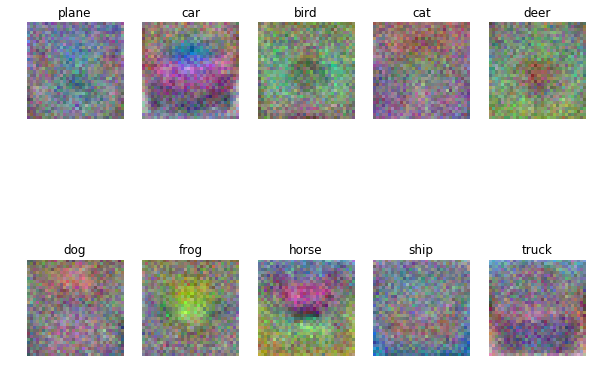

In [16]:
# Visualize the learned weights for each class
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])